# Method 7 - Rest Ideas After 1

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 1].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

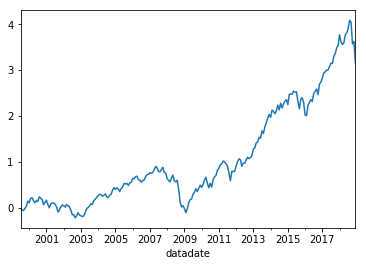

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.141884
2000-12-31   -0.025556
2001-12-31   -0.050176
2002-12-31   -0.208950
2003-12-31    0.459705
2004-12-31    0.176117
2005-12-31    0.079440
2006-12-31    0.112700
2007-12-31    0.018175
2008-12-31   -0.405895
2009-12-31    0.425815
2010-12-31    0.222562
2011-12-31   -0.015211
2012-12-31    0.193587
2013-12-31    0.418968
2014-12-31    0.107270
2015-12-31   -0.020058
2016-12-31    0.136659
2017-12-31    0.214822
2018-12-31   -0.084424
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2903.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.00e-195
Time:                        22:24:54   Log-Likelihood:                 837.49
No. Observations:                 234   AIC:                            -1665.
Df Residuals:                     229   BIC:                            -1648.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.737      0.000       0.001       0.003
mktrf          1.0150      0.013     79.740      0.000       0.990       1.040
me             0.2777      0.015     18.754      0.000       0.249       0.307
ia             0.0438      0.023      1.946      0.053      -0.001       0.088
roe           -0.0353      0.019     -1.830      0.069      -0.073       0.003
==============================================================================
Omnibus:                       27.551   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.443
Skew:                          -0.174   Prob(JB):                     2.35e-30
Kurtosis:                       6.725   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1911.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.37e-174
Time:                        22:24:54   Log-Likelihood:                 837.49
No. Observations:                 234   AIC:                            -1665.
Df Residuals:                     229   BIC:                            -1648.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.846      0.000       0.001       0.003
mktrf          1.0150      0.016     64.547      0.000       0.984       1.046
me             0.2777      0.023     11.997      0.000       0.232       0.323
ia             0.0438      0.045      0.967      0.334      -0.045       0.133
roe           -0.0353      0.026     -1.357      0.175      -0.086       0.016
==============================================================================
Omnibus:                       27.551   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.443
Skew:                          -0.174   Prob(JB):                     2.35e-30
Kurtosis:                       6.725   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2399.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.38e-185
Time:                        22:24:54   Log-Likelihood:                 837.49
No. Observations:                 234   AIC:                            -1665.
Df Residuals:                     229   BIC:                            -1648.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      5.202      0.000       0.001       0.003
mktrf          1.0150      0.015     66.614      0.000       0.985       1.045
me             0.2777      0.022     12.647      0.000       0.235       0.321
ia             0.0438      0.047      0.939      0.348      -0.048       0.135
roe           -0.0353      0.029     -1.217      0.224      -0.092       0.022
==============================================================================
Omnibus:                       27.551   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.443
Skew:                          -0.174   Prob(JB):                     2.35e-30
Kurtosis:                       6.725   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1931.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.16e-184
Time:                        22:24:54   Log-Likelihood:                 816.85
No. Observations:                 234   AIC:                            -1622.
Df Residuals:                     228   BIC:                            -1601.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.814      0.000       0.001       0.003
mktrf          1.0273      0.014     73.588      0.000       1.000       1.055
smb            0.3029      0.018     16.443      0.000       0.267       0.339
hml            0.0182      0.022      0.836      0.404      -0.025       0.061
rmw           -0.0176      0.025     -0.716      0.474      -0.066       0.031
cma            0.0410      0.031      1.312      0.191      -0.021       0.102
==============================================================================
Omnibus:                       26.530   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.428
Skew:                          -0.026   Prob(JB):                     1.44e-30
Kurtosis:                       6.754   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1611.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.19e-175
Time:                        22:24:54   Log-Likelihood:                 816.85
No. Observations:                 234   AIC:                            -1622.
Df Residuals:                     228   BIC:                            -1601.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.572      0.000       0.001       0.003
mktrf          1.0273      0.018     56.971      0.000       0.992       1.063
smb            0.3029      0.023     12.914      0.000       0.257       0.349
hml            0.0182      0.048      0.375      0.708      -0.077       0.113
rmw           -0.0176      0.028     -0.619      0.536      -0.073       0.038
cma            0.0410      0.051      0.798      0.425      -0.060       0.141
==============================================================================
Omnibus:                       26.530   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.428
Skew:                          -0.026   Prob(JB):                     1.44e-30
Kurtosis:                       6.754   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2282.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.75e-192
Time:                        22:24:55   Log-Likelihood:                 816.85
No. Observations:                 234   AIC:                            -1622.
Df Residuals:                     228   BIC:                            -1601.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.534      0.000       0.001       0.003
mktrf          1.0273      0.017     58.707      0.000       0.993       1.062
smb            0.3029      0.024     12.821      0.000       0.257       0.349
hml            0.0182      0.051      0.357      0.721      -0.081       0.118
rmw           -0.0176      0.031     -0.576      0.564      -0.077       0.042
cma            0.0410      0.051      0.811      0.417      -0.058       0.140
==============================================================================
Omnibus:                       26.530   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.428
Skew:                          -0.026   Prob(JB):                     1.44e-30
Kurtosis:                       6.754   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2178.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.50e-181
Time:                        22:24:55   Log-Likelihood:                 804.62
No. Observations:                 234   AIC:                            -1599.
Df Residuals:                     229   BIC:                            -1582.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.974      0.000       0.001       0.003
mktrf          1.0252      0.013     76.013      0.000       0.999       1.052
smb            0.2930      0.017     17.406      0.000       0.260       0.326
hml            0.0857      0.017      5.127      0.000       0.053       0.119
umd           -0.0079      0.011     -0.719      0.473      -0.030       0.014
==============================================================================
Omnibus:                       27.496   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.588
Skew:                           0.012   Prob(JB):                     3.29e-33
Kurtosis:                       6.917   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2020.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.97e-177
Time:                        22:24:55   Log-Likelihood:                 804.62
No. Observations:                 234   AIC:                            -1599.
Df Residuals:                     229   BIC:                            -1582.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.299      0.001       0.001       0.003
mktrf          1.0252      0.018     55.641      0.000       0.989       1.061
smb            0.2930      0.024     12.162      0.000       0.246       0.340
hml            0.0857      0.048      1.794      0.073      -0.008       0.179
umd           -0.0079      0.020     -0.393      0.694      -0.047       0.031
==============================================================================
Omnibus:                       27.496   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.588
Skew:                           0.012   Prob(JB):                     3.29e-33
Kurtosis:                       6.917   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2684.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.64e-191
Time:                        22:24:55   Log-Likelihood:                 804.62
No. Observations:                 234   AIC:                            -1599.
Df Residuals:                     229   BIC:                            -1582.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.252      0.001       0.001       0.003
mktrf          1.0252      0.016     65.655      0.000       0.995       1.056
smb            0.2930      0.025     11.625      0.000       0.244       0.342
hml            0.0857      0.053      1.628      0.104      -0.017       0.189
umd           -0.0079      0.016     -0.490      0.624      -0.039       0.024
==============================================================================
Omnibus:                       27.496   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.588
Skew:                           0.012   Prob(JB):                     3.29e-33
Kurtosis:                       6.917   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1285.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.03e-94
Time:                        22:24:55   Log-Likelihood:                 410.01
No. Observations:                 120   AIC:                            -810.0
Df Residuals:                     115   BIC:                            -796.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.620      0.000       0.001       0.004
mktrf          1.0240      0.021     48.975      0.000       0.983       1.065
me             0.2602      0.021     12.600      0.000       0.219       0.301
ia             0.0792      0.032      2.449      0.016       0.015       0.143
roe           -0.0273      0.029     -0.954      0.342      -0.084       0.029
==============================================================================
Omnibus:                       10.880   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               27.376
Skew:                          -0.123   Prob(JB):                     1.14e-06
Kurtosis:                       5.327   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1083.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.97e-90
Time:                        22:24:55   Log-Likelihood:                 410.01
No. Observations:                 120   AIC:                            -810.0
Df Residuals:                     115   BIC:                            -796.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.674      0.000       0.001       0.004
mktrf          1.0240      0.027     38.317      0.000       0.972       1.076
me             0.2602      0.024     10.892      0.000       0.213       0.307
ia             0.0792      0.050      1.580      0.114      -0.019       0.177
roe           -0.0273      0.031     -0.871      0.384      -0.089       0.034
==============================================================================
Omnibus:                       10.880   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               27.376
Skew:                          -0.123   Prob(JB):                     1.14e-06
Kurtosis:                       5.327   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1696.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.33e-101
Time:                        22:24:55   Log-Likelihood:                 410.01
No. Observations:                 120   AIC:                            -810.0
Df Residuals:                     115   BIC:                            -796.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.737      0.000       0.001       0.004
mktrf          1.0240      0.023     44.385      0.000       0.979       1.069
me             0.2602      0.023     11.324      0.000       0.215       0.305
ia             0.0792      0.045      1.753      0.080      -0.009       0.168
roe           -0.0273      0.032     -0.851      0.395      -0.090       0.036
==============================================================================
Omnibus:                       10.880   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               27.376
Skew:                          -0.123   Prob(JB):                     1.14e-06
Kurtosis:                       5.327   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     824.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-87
Time:                        22:24:55   Log-Likelihood:                 397.61
No. Observations:                 120   AIC:                            -783.2
Df Residuals:                     114   BIC:                            -766.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.473      0.001       0.001       0.005
mktrf          1.0648      0.025     43.362      0.000       1.016       1.113
smb            0.3007      0.028     10.814      0.000       0.246       0.356
hml           -0.0089      0.034     -0.261      0.795      -0.076       0.059
rmw            0.0197      0.040      0.490      0.625      -0.060       0.099
cma            0.1058      0.044      2.403      0.018       0.019       0.193
==============================================================================
Omnibus:                       12.196   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               32.012
Skew:                          -0.198   Prob(JB):                     1.12e-07
Kurtosis:                       5.499   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     967.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.45e-91
Time:                        22:24:55   Log-Likelihood:                 397.61
No. Observations:                 120   AIC:                            -783.2
Df Residuals:                     114   BIC:                            -766.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.386      0.001       0.001       0.005
mktrf          1.0648      0.035     30.557      0.000       0.996       1.133
smb            0.3007      0.036      8.314      0.000       0.230       0.372
hml           -0.0089      0.079     -0.112      0.911      -0.164       0.146
rmw            0.0197      0.061      0.323      0.746      -0.100       0.139
cma            0.1058      0.064      1.658      0.097      -0.019       0.231
==============================================================================
Omnibus:                       12.196   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               32.012
Skew:                          -0.198   Prob(JB):                     1.12e-07
Kurtosis:                       5.499   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1802.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.08e-106
Time:                        22:24:55   Log-Likelihood:                 397.61
No. Observations:                 120   AIC:                            -783.2
Df Residuals:                     114   BIC:                            -766.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.488      0.000       0.001       0.005
mktrf          1.0648      0.033     31.970      0.000       0.999       1.130
smb            0.3007      0.037      8.152      0.000       0.228       0.373
hml           -0.0089      0.085     -0.105      0.917      -0.175       0.157
rmw            0.0197      0.066      0.298      0.766      -0.110       0.149
cma            0.1058      0.063      1.679      0.093      -0.018       0.229
==============================================================================
Omnibus:                       12.196   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               32.012
Skew:                          -0.198   Prob(JB):                     1.12e-07
Kurtosis:                       5.499   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     901.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.64e-86
Time:                        22:24:55   Log-Likelihood:                 389.26
No. Observations:                 120   AIC:                            -768.5
Df Residuals:                     115   BIC:                            -754.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.903      0.000       0.002       0.005
mktrf          1.0402      0.022     47.507      0.000       0.997       1.084
smb            0.2814      0.025     11.286      0.000       0.232       0.331
hml            0.1044      0.025      4.182      0.000       0.055       0.154
umd           -0.0032      0.015     -0.207      0.837      -0.034       0.027
==============================================================================
Omnibus:                       13.063   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               39.522
Skew:                          -0.134   Prob(JB):                     2.62e-09
Kurtosis:                       5.799   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1404.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.42e-96
Time:                        22:24:55   Log-Likelihood:                 389.26
No. Observations:                 120   AIC:                            -768.5
Df Residuals:                     115   BIC:                            -754.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.009      0.000       0.002       0.005
mktrf          1.0402      0.029     35.288      0.000       0.982       1.098
smb            0.2814      0.028      9.893      0.000       0.226       0.337
hml            0.1044      0.060      1.738      0.082      -0.013       0.222
umd           -0.0032      0.024     -0.133      0.894      -0.050       0.044
==============================================================================
Omnibus:                       13.063   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               39.522
Skew:                          -0.134   Prob(JB):                     2.62e-09
Kurtosis:                       5.799   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     2395.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.05e-109
Time:                        22:24:55   Log-Likelihood:                 389.26
No. Observations:                 120   AIC:                            -768.5
Df Residuals:                     115   BIC:                            -754.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.198      0.000       0.002       0.005
mktrf          1.0402      0.022     46.419      0.000       0.996       1.084
smb            0.2814      0.030      9.536      0.000       0.224       0.339
hml            0.1044      0.065      1.614      0.107      -0.022       0.231
umd           -0.0032      0.018     -0.176      0.860      -0.039       0.032
==============================================================================
Omnibus:                       13.063   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               39.522
Skew:                          -0.134   Prob(JB):                     2.62e-09
Kurtosis:                       5.799   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2556.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.01e-106
Time:                        22:24:55   Log-Likelihood:                 459.13
No. Observations:                 114   AIC:                            -908.3
Df Residuals:                     109   BIC:                            -894.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      4.108      0.000       0.001       0.003
mktrf          1.0063      0.013     77.625      0.000       0.981       1.032
me             0.3173      0.020     15.853      0.000       0.278       0.357
ia            -0.0861      0.028     -3.100      0.002      -0.141      -0.031
roe           -0.1049      0.024     -4.301      0.000      -0.153      -0.057
==============================================================================
Omnibus:                       11.238   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.747
Skew:                          -0.673   Prob(JB):                      0.00281
Kurtosis:                       3.813   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4447.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.01e-119
Time:                        22:24:55   Log-Likelihood:                 459.13
No. Observations:                 114   AIC:                            -908.3
Df Residuals:                     109   BIC:                            -894.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      4.228      0.000       0.001       0.003
mktrf          1.0063      0.009    109.307      0.000       0.988       1.024
me             0.3173      0.017     18.908      0.000       0.284       0.350
ia            -0.0861      0.030     -2.902      0.004      -0.144      -0.028
roe           -0.1049      0.024     -4.434      0.000      -0.151      -0.059
==============================================================================
Omnibus:                       11.238   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.747
Skew:                          -0.673   Prob(JB):                      0.00281
Kurtosis:                       3.813   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     5140.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.95e-123
Time:                        22:24:55   Log-Likelihood:                 459.13
No. Observations:                 114   AIC:                            -908.3
Df Residuals:                     109   BIC:                            -894.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      4.077      0.000       0.001       0.003
mktrf          1.0063      0.009    113.810      0.000       0.989       1.024
me             0.3173      0.017     19.053      0.000       0.285       0.350
ia            -0.0861      0.033     -2.637      0.008      -0.150      -0.022
roe           -0.1049      0.023     -4.645      0.000      -0.149      -0.061
==============================================================================
Omnibus:                       11.238   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.747
Skew:                          -0.673   Prob(JB):                      0.00281
Kurtosis:                       3.813   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2727.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.78e-112
Time:                        22:24:55   Log-Likelihood:                 475.92
No. Observations:                 114   AIC:                            -939.8
Df Residuals:                     108   BIC:                            -923.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.445      0.016       0.000       0.002
mktrf          1.0122      0.011     94.414      0.000       0.991       1.033
smb            0.2923      0.017     16.797      0.000       0.258       0.327
hml            0.0086      0.022      0.386      0.700      -0.035       0.053
rmw           -0.1675      0.027     -6.165      0.000      -0.221      -0.114
cma           -0.1049      0.035     -3.039      0.003      -0.173      -0.036
==============================================================================
Omnibus:                       10.028   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.012
Skew:                          -0.674   Prob(JB):                      0.00670
Kurtosis:                       3.540   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2827.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.89e-113
Time:                        22:24:55   Log-Likelihood:                 475.92
No. Observations:                 114   AIC:                            -939.8
Df Residuals:                     108   BIC:                            -923.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.383      0.017       0.000       0.002
mktrf          1.0122      0.010    106.349      0.000       0.994       1.031
smb            0.2923      0.016     17.760      0.000       0.260       0.325
hml            0.0086      0.020      0.425      0.671      -0.031       0.048
rmw           -0.1675      0.023     -7.264      0.000      -0.213      -0.122
cma           -0.1049      0.037     -2.854      0.004      -0.177      -0.033
==============================================================================
Omnibus:                       10.028   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.012
Skew:                          -0.674   Prob(JB):                      0.00670
Kurtosis:                       3.540   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     4709.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.27e-124
Time:                        22:24:55   Log-Likelihood:                 475.92
No. Observations:                 114   AIC:                            -939.8
Df Residuals:                     108   BIC:                            -923.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.125      0.034    7.27e-05       0.002
mktrf          1.0122      0.008    124.495      0.000       0.996       1.028
smb            0.2923      0.015     19.710      0.000       0.263       0.321
hml            0.0086      0.020      0.435      0.664      -0.030       0.047
rmw           -0.1675      0.025     -6.587      0.000      -0.217      -0.118
cma           -0.1049      0.037     -2.811      0.005      -0.178      -0.032
==============================================================================
Omnibus:                       10.028   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.012
Skew:                          -0.674   Prob(JB):                      0.00670
Kurtosis:                       3.540   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2295.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.33e-104
Time:                        22:24:55   Log-Likelihood:                 453.06
No. Observations:                 114   AIC:                            -896.1
Df Residuals:                     109   BIC:                            -882.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.147      0.254      -0.000       0.001
mktrf          1.0253      0.013     79.131      0.000       1.000       1.051
smb            0.3308      0.020     16.376      0.000       0.291       0.371
hml           -0.0008      0.021     -0.039      0.969      -0.042       0.040
umd           -0.0279      0.016     -1.775      0.079      -0.059       0.003
==============================================================================
Omnibus:                        5.306   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                4.755
Skew:                          -0.477   Prob(JB):                       0.0928
Kurtosis:                       3.305   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1735.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.14e-97
Time:                        22:24:55   Log-Likelihood:                 453.06
No. Observations:                 114   AIC:                            -896.1
Df Residuals:                     109   BIC:                            -882.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.086      0.278      -0.000       0.001
mktrf          1.0253      0.014     74.708      0.000       0.998       1.052
smb            0.3308      0.018     18.463      0.000       0.296       0.366
hml           -0.0008      0.019     -0.042      0.967      -0.039       0.037
umd           -0.0279      0.011     -2.445      0.014      -0.050      -0.006
==============================================================================
Omnibus:                        5.306   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                4.755
Skew:                          -0.477   Prob(JB):                       0.0928
Kurtosis:                       3.305   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3095.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.32e-111
Time:                        22:24:55   Log-Likelihood:                 453.06
No. Observations:                 114   AIC:                            -896.1
Df Residuals:                     109   BIC:                            -882.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.070      0.284      -0.000       0.002
mktrf          1.0253      0.013     80.198      0.000       1.000       1.050
smb            0.3308      0.014     24.493      0.000       0.304       0.357
hml           -0.0008      0.017     -0.048      0.962      -0.034       0.032
umd           -0.0279      0.011     -2.562      0.010      -0.049      -0.007
==============================================================================
Omnibus:                        5.306   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.070   Jarque-Bera (JB):                4.755
Skew:                          -0.477   Prob(JB):                       0.0928
Kurtosis:                       3.305   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""